In [1]:
# =====================================================
# HÜCRE 1 – KÜTÜPHANELERİN YÜKLENMESİ (REGRESYON)
# Bu hücrede:
# - Veri işleme, modelleme ve görselleştirme için gerekli kütüphaneler yüklenir.
# - Uyarı (warning) mesajları kapatılır.
# =====================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

from scipy.sparse import hstack

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Tüm kütüphaneler yüklendi.")


Tüm kütüphaneler yüklendi.


In [2]:
# =====================================================
# HÜCRE 2 – VERİYİ YÜKLEME VE SADECE HOURLY İLANLARIN SEÇİLMESİ
# Bu hücrede:
# 1) CSV dosyası okunur.
# 2) Başlığı (title) boş olan satırlar temizlenir.
# 3) is_hourly sütunu 0 (Fixed) / 1 (Hourly) olarak dönüştürülür.
# 4) Sadece Hourly ilanlar filtrelenir.
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

df = pd.read_csv(csv_path, low_memory=False)

df = df.dropna(subset=["title"]).copy()

def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    elif s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

df = df[df["is_hourly"] == 1].copy()

print(f"Toplam Hourly ilan sayısı: {df.shape[0]:,}")


Toplam Hourly ilan sayısı: 140,936


In [3]:
# =====================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TF-IDF
# Bu hücrede:
# 1) Başlık uzunluğu ve kelime sayısı gibi metin temelli sayısal özellikler üretilir.
# 2) Bütçe, saatlik ücret ve ülke bilgisinden ek özellikler çıkarılır.
# 3) Title alanı TF-IDF ile vektörleştirilir.
# 4) Metin ve sayısal özellikler tek bir özellik matrisi altında birleştirilir.
# 5) Hedef değişken avg_hourly (saatlik ücret ortalaması) olarak tanımlanır.
# =====================================================

df["title_length"] = df["title"].astype(str).str.len()
df["word_count"] = df["title"].astype(str).str.split().str.len()

df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1)

df = df.dropna(subset=["avg_hourly"]).copy()

df["budget_filled"] = df["budget"].fillna(0)

top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_numeric = df[numeric_cols].values

X = hstack([X_text, X_numeric])

y = df["avg_hourly"].astype(float).values

print(f"{X.shape[1]} özellik, Train/Test ayrımına hazır. Hedef değişken: avg_hourly")


1007 özellik, Train/Test ayrımına hazır. Hedef değişken: avg_hourly


In [6]:
# =====================================================
# HÜCRE 4 – TRAIN/TEST AYIRIMI (REGRESYON)
# Bu hücrede:
# 1) X ve y eğitim ve test setlerine ayrılır.
# 2) Rastgelelik kontrolü için random_state sabit tutulur.
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"{X.shape[1]} özellik, Train: {X_train.shape[0]:,}, Test: {X_test.shape[0]:,}")


# Bu fonksiyon:
# - R-kare (R2), MSE, RMSE, MAE, MAPE metriklerini hesaplar.
# =====================================================

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))
    ) * 100
    r2 = r2_score(y_true, y_pred)
    return r2, mse, rmse, mae, mape



1007 özellik, Train: 81,937, Test: 20,485


In [7]:
# =====================================================
# HÜCRE 5 – SKLEARN REGRESYON MODELLERİ
# Bu hücrede:
# 1) Linear Regression modeli eğitilir ve değerlendirilir.
# 2) Ridge Regression için GridSearchCV ile en iyi alpha bulunur.
# 3) RandomForestRegressor için GridSearchCV ile temel hiperparametreler ayarlanır.
# 4) Tüm modeller için R2, MSE, RMSE, MAE, MAPE metrikleri hesaplanır ve tablo halinde kaydedilir.
# =====================================================

print("\n" + "="*70)
print("SKLEARN REGRESYON MODELLERİ")
print("="*70)

sklearn_results = []

print("\n1. Linear Regression modeli eğitiliyor...")

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_lin)
sklearn_results.append({
    "Model": "Linear Regression",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("\n2. Ridge Regression (GridSearchCV) eğitiliyor...")

ridge_params = {
    "alpha": [0.1, 1.0, 10.0]
}
ridge = Ridge(random_state=42)

ridge_grid = GridSearchCV(
    ridge,
    ridge_params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
ridge_grid.fit(X_train, y_train)

y_pred_ridge = ridge_grid.best_estimator_.predict(X_test)
r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_ridge)
sklearn_results.append({
    "Model": "Ridge Regression",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("En iyi Ridge parametreleri:", ridge_grid.best_params_)

print("\n3. RandomForestRegressor (GridSearchCV) eğitiliyor...")

rf_params = {
    "n_estimators": [100],
    "max_depth": [15, 20],
    "min_samples_split": [5]
}
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    rf_reg,
    rf_params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
r2, mse, rmse, mae, mape = regression_metrics(y_test, y_pred_rf)
sklearn_results.append({
    "Model": "RandomForestRegressor",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

print("En iyi RF parametreleri:", rf_grid.best_params_)

print("\n" + "="*70)
print("SKLEARN REGRESYON PERFORMANSI")
print("="*70)

sklearn_df = pd.DataFrame(sklearn_results).round(4)
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv("abdulkerim_sklearn_regression_models.csv", index=False)
print("\nKaydedildi: abdulkerim_sklearn_regression_models.csv")



SKLEARN REGRESYON MODELLERİ

1. Linear Regression modeli eğitiliyor...

2. Ridge Regression (GridSearchCV) eğitiliyor...
En iyi Ridge parametreleri: {'alpha': 10.0}

3. RandomForestRegressor (GridSearchCV) eğitiliyor...
En iyi RF parametreleri: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

SKLEARN REGRESYON PERFORMANSI
                Model     R2    MSE   RMSE    MAE   MAPE
    Linear Regression 1.0000 0.0000 0.0001 0.0000 0.0003
     Ridge Regression 1.0000 0.0009 0.0292 0.0250 0.1652
RandomForestRegressor 0.9999 0.1160 0.3405 0.0057 0.0015

Kaydedildi: abdulkerim_sklearn_regression_models.csv


In [8]:
# =====================================================
# HÜCRE 6 – PYTORCH İÇİN VERİ HAZIRLAMA (REGRESYON)
# Bu hücrede:
# 1) Seyrek (sparse) X_train ve X_test matrisleri dense formata dönüştürülür.
# 2) Özellikler StandardScaler ile ölçeklenir.
# 3) PyTorch Dataset ve DataLoader nesneleri oluşturulur.
# 4) Kayıp fonksiyonu olarak MSELoss seçilir.
# =====================================================

X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

y_train_np = y_train.astype(np.float32)
y_test_np = y_test.astype(np.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

pytorch_results = []
loss_fn = nn.MSELoss()


Kullanılan cihaz: cpu


In [9]:
# =====================================================
# HÜCRE 7 – MLP REGRESYON MODELİNİN EĞİTİLMESİ
# Bu hücrede:
# 1) Tam bağlantılı bir MLP mimarisi tanımlanır.
# 2) 5 epoch boyunca eğitim yapılır.
# 3) Test seti üzerinde tahminler alınır ve regresyon metrikleri hesaplanır.
# =====================================================

print("\nPyTorch Model 1: MLP (Regresyon, 5 epoch) eğitiliyor...")

class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

mlp_model = MLPModel(X_train_scaled.shape[1]).to(device)
optim_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_mlp)
pytorch_results.append({
    "Model": "MLP",
    "Mimari": "128-64-1",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})



PyTorch Model 1: MLP (Regresyon, 5 epoch) eğitiliyor...
Epoch 1/5 - Ortalama Kayıp (MSE): 388.4220
Epoch 2/5 - Ortalama Kayıp (MSE): 74.0643
Epoch 3/5 - Ortalama Kayıp (MSE): 56.1510
Epoch 4/5 - Ortalama Kayıp (MSE): 48.7028
Epoch 5/5 - Ortalama Kayıp (MSE): 46.9396


In [10]:
# =====================================================
# HÜCRE 8 – LSTM REGRESYON MODELİNİN EĞİTİLMESİ
# Bu hücrede:
# 1) LSTM tabanlı bir mimari tanımlanır.
# 2) 5 epoch boyunca eğitim yapılır.
# 3) Test seti üzerinde tahminler alınır ve regresyon metrikleri hesaplanır.
# Not: Veri zamansal olmasa da, LSTM modelinin kullanımı ödev kapsamında denenmektedir.
# =====================================================

print("\nPyTorch Model 2: LSTM (Regresyon, 5 epoch) eğitiliyor...")

class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp (MSE): {epoch_loss/len(train_loader):.4f}")

lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()

r2, mse, rmse, mae, mape = regression_metrics(y_test_np, y_pred_lstm)
pytorch_results.append({
    "Model": "LSTM",
    "Mimari": "LSTM(64)-32-1",
    "R2": r2,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape
})

pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH REGRESYON PERFORMANSI")
print(pytorch_df)

pytorch_df.to_csv("abdulkerim_pytorch_regression_models.csv", index=False)
print("\nKaydedildi: abdulkerim_pytorch_regression_models.csv")



PyTorch Model 2: LSTM (Regresyon, 5 epoch) eğitiliyor...
Epoch 1/5 - Ortalama Kayıp (MSE): 723.4333
Epoch 2/5 - Ortalama Kayıp (MSE): 158.8033
Epoch 3/5 - Ortalama Kayıp (MSE): 82.5241
Epoch 4/5 - Ortalama Kayıp (MSE): 58.8950
Epoch 5/5 - Ortalama Kayıp (MSE): 48.8301

PYTORCH REGRESYON PERFORMANSI
  Model         Mimari      R2      MSE    RMSE     MAE     MAPE
0   MLP       128-64-1  0.9798  18.1819  4.2640  3.0275  19.9848
1  LSTM  LSTM(64)-32-1  0.8954  94.1315  9.7021  4.0765  21.6287

Kaydedildi: abdulkerim_pytorch_regression_models.csv


Kaydedildi: abdulkerim_regression_plots.png


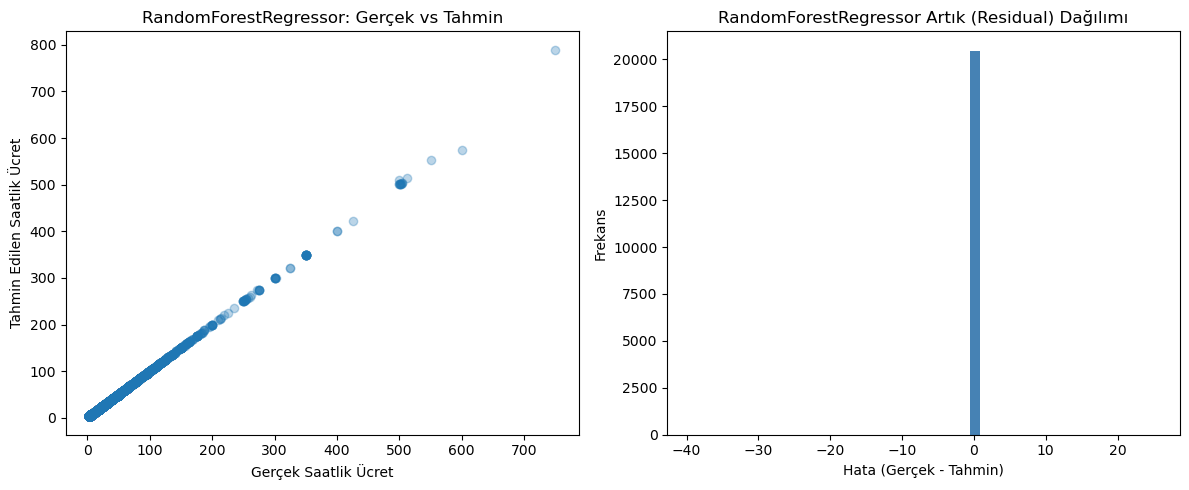


Abdulkerim için regresyon projesi tamamlandı.


In [11]:
# =====================================================
# HÜCRE 9 – REGRESYON GÖRSELLERİ VE SONUÇLARIN ÖZETLENMESİ
# Bu hücrede:
# 1) Gerçek ve tahmin edilen saatlik ücretler için saçılım grafiği çizilir.
# 2) Hata (residual) dağılımı gösterilir.
# 3) Çalışmanın tamamlandığı bilgisi ekrana yazdırılır.
# =====================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test_np, y_pred_rf, alpha=0.3)
axes[0].set_xlabel("Gerçek Saatlik Ücret")
axes[0].set_ylabel("Tahmin Edilen Saatlik Ücret")
axes[0].set_title("RandomForestRegressor: Gerçek vs Tahmin")

residuals = y_test_np - y_pred_rf
axes[1].hist(residuals, bins=50, color="steelblue")
axes[1].set_title("RandomForestRegressor Artık (Residual) Dağılımı")
axes[1].set_xlabel("Hata (Gerçek - Tahmin)")
axes[1].set_ylabel("Frekans")

plt.tight_layout()
plt.savefig("abdulkerim_regression_plots.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: abdulkerim_regression_plots.png")
plt.show()

print("\nAbdulkerim için regresyon projesi tamamlandı.")


Kaydedildi: abdulkerim_regression_diagnostic_plots.png


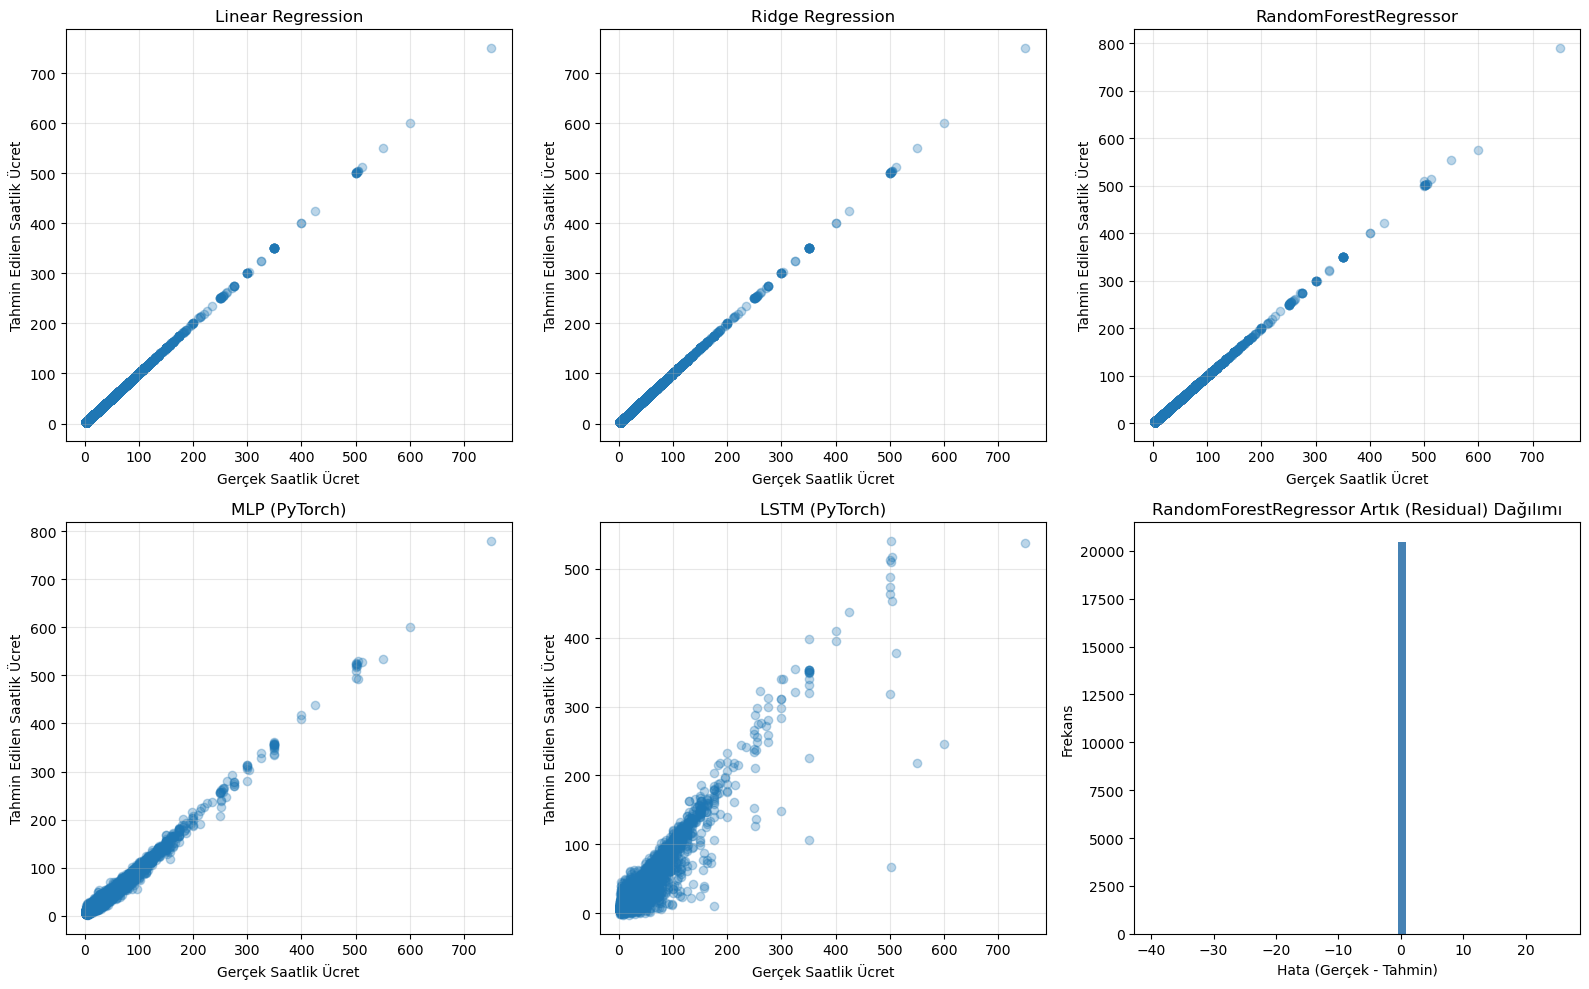

Kaydedildi: abdulkerim_regression_r2_comparison.png


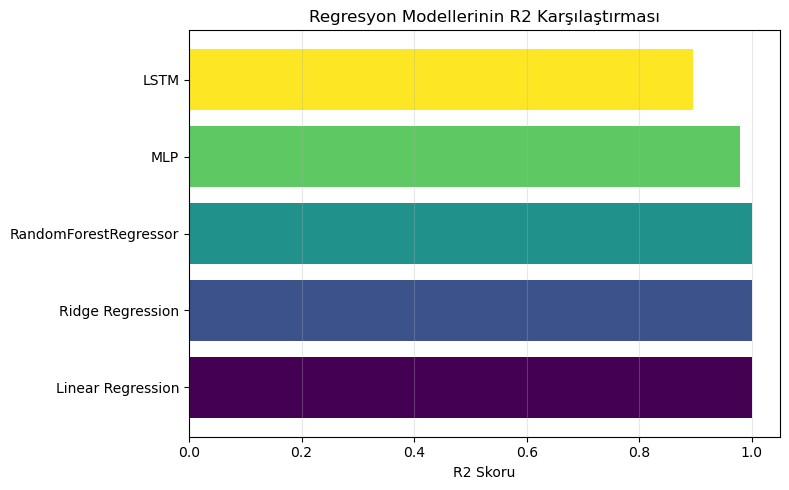


Abdulkerim için regresyon projesi görselleri oluşturuldu.


In [12]:
# =====================================================
# HÜCRE 10 – REGRESYON GÖRSELLERİ VE SONUÇLARIN ÖZETLENMESİ
# Bu hücrede:
# 1) Farklı modeller için gerçek vs tahmin edilen saatlik ücret grafikleri çizilir.
# 2) Rastgele seçilen bir model için hata (residual) dağılımı gösterilir.
# 3) Tüm modellerin R2 skorları bar grafiği ile özetlenir.[27]
# =====================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

model_predictions = [
    (y_pred_lin,   "Linear Regression",         axes[0, 0]),
    (y_pred_ridge, "Ridge Regression",         axes[0, 1]),
    (y_pred_rf,    "RandomForestRegressor",    axes[0, 2]),
    (y_pred_mlp,   "MLP (PyTorch)",            axes[1, 0]),
    (y_pred_lstm,  "LSTM (PyTorch)",           axes[1, 1]),
]

for y_hat, label, ax in model_predictions:
    ax.scatter(y_test_np, y_hat, alpha=0.3)
    ax.set_xlabel("Gerçek Saatlik Ücret")
    ax.set_ylabel("Tahmin Edilen Saatlik Ücret")
    ax.set_title(label)
    ax.grid(alpha=0.3)

# Rastgele bir model (örnek: RandomForestRegressor) için residual dağılımı
residuals_rf = y_test_np - y_pred_rf
ax = axes[1, 2]
ax.hist(residuals_rf, bins=50, color="steelblue")
ax.set_title("RandomForestRegressor Artık (Residual) Dağılımı")
ax.set_xlabel("Hata (Gerçek - Tahmin)")
ax.set_ylabel("Frekans")

plt.tight_layout()
plt.savefig("abdulkerim_regression_diagnostic_plots.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: abdulkerim_regression_diagnostic_plots.png")
plt.show()

# Modellerin R2 skorlarının özetlenmesi
model_names = [
    "Linear Regression",
    "Ridge Regression",
    "RandomForestRegressor",
    "MLP",
    "LSTM"
]

r2_scores = [
    r2_score(y_test_np, y_pred_lin),
    r2_score(y_test_np, y_pred_ridge),
    r2_score(y_test_np, y_pred_rf),
    r2_score(y_test_np, y_pred_mlp),
    r2_score(y_test_np, y_pred_lstm),
]

plt.figure(figsize=(8, 5))
plt.barh(model_names, r2_scores, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
plt.xlabel("R2 Skoru")
plt.title("Regresyon Modellerinin R2 Karşılaştırması")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("abdulkerim_regression_r2_comparison.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: abdulkerim_regression_r2_comparison.png")
plt.show()

print("\nAbdulkerim için regresyon projesi görselleri oluşturuldu.")
